# Exploratory Data Analysis: Gene Ontology (GO) Graph

***Basic operations on graphs***
- Create a graph
- Add nodes
- Add edges
- Analyze graph and nodes' degrees
- Add nodes and edges attributes
- Analyze graph connectivity
- Visualize a graph

***GO graph EDA***
- Read and parse the [GO graph](https://geneontology.org/docs/download-ontology) file
- Check graph type
- Visualize nodes' degree distribution
- Extract and analyze nodes' attributes
- Split the GO graph
- Plot sub-graphs
- Create a dataframe with nodes' attributes

## **Environment Setup**

In [1]:
# install required libraries (required for Colab, Kaggle)

# !pip install obonet networkx

In [2]:
# home directory

from pathlib import Path

home_dir = Path("/home/clever/datascience/portfolio/go_graph/")
# print(f"Home dir: {home_dir.as_posix()}")

In [3]:
# custom functions

# plot graphs or sub-graphs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pylab import rcParams


def plot_graph(
    G: nx.Graph(),
    plot_nodes=list,
    plot_all=False,
    num_nodes=50,
    iterations=100,
    figure_size=(12, 12),
    node_color="green",
):
    """
    Plot the full graph (plot_all=True) or a sub-graph with the
    nodes passed as parameter. The 'n_terms' parameter controls
    how many nodes will be plotted in the top-down list of nodes.

    G: nx.Graph
    plot_nodes: list with the nodes to plot
    plot_all: select wheter plot the full graph or a subgraph
    n_nodes: number of nodes to plot
    iterations: number of iterations of spring_layout algorithm
    figure_size: tuple with figure dimensions (W x H)
    """
    if plot_all:
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)
        print(f"Plotting full graph with {n_nodes} nodes and {n_edges} edges...")
    else:
        G = nx.subgraph(G, plot_nodes[:num_nodes])
        n_nodes = len(G.nodes)
        n_edges = len(G.edges)
        print(f"Plotting subgraph with {n_nodes} nodes and {n_edges} edges...")

    # set figure size
    rcParams["figure.figsize"] = figure_size

    # nodes features
    degree_dict = dict(G.degree)  # get degree to adjust node viz
    node_size = list([x * 100 for x in degree_dict.values()])
    node_alpha = [float(x / max(degree_dict.values())) for x in degree_dict.values()]

    pos = nx.spring_layout(
        G,
        scale=10,
        k=25 / np.sqrt(n_nodes),
        seed=13,
        iterations=iterations,
    )

    ax = nx.draw_networkx_nodes(
        G, pos, node_size=node_size, alpha=node_alpha, node_color=node_color
    )

    ax = nx.draw_networkx_edges(
        G, pos, width=0.5, node_size=node_size, edge_color="grey"
    )

    ax = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color="grey",
        horizontalalignment="center",
        verticalalignment="center",
    )

    plt.show()


# convert list of tuples into Python dict type


def tuple_to_dict(t: tuple, d: dict):
    d = dict(t)
    return d


# plot histograms with the degree distribution of a graph


def plot_hist_degree(G: nx.Graph, bins=15):
    # retrieve nodes' degrees (GO term ID, degree)
    degree_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)

    # converto into dict
    degree_desc_dict = {}
    degree_desc_dict = tuple_to_dict(degree_desc, degree_desc_dict)

    # plot degrees

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    fig.suptitle("GO Graph Degree Distribution")

    sns.histplot(ax=axs[0], data=degree_desc_dict.values(), bins=bins, legend=False)
    axs[0].set_title("Degree Distribution")
    axs[0].set_xlabel("Degree")

    sns.histplot(
        ax=axs[1],
        data=degree_desc_dict.values(),
        bins=bins,
        log_scale=True,
        legend=False,
    )
    axs[1].set_title("Log Degree Distribution")
    axs[1].set_xlabel("log(degree)")
    plt.show()

## **Basic Operations on Graphs**

To start, we will create a directed acyclic graph, almost the same type of graph used by the Gene Ontology Consortium to organize more than 40,000 GO terms. The difference is that the GO terms are organized in a directed acyclic multigraph, where we can have more than one edge connecting two nodes.

>For an in-depth overview how to create and manipulate graphs [NetworkX documentation](https://networkx.org/).

In [4]:
graph = nx.DiGraph()  # empty directed graph instance
type(graph)

networkx.classes.digraph.DiGraph

#### **Adding Nodes and Edges**

The graph we've just created is empty. We will populate the graph with nodes and edges, and later add attributes to them.

Nodes can be any type of hashable object: lists, files, arrays, *tensors* (a special type of *array*), functions, object instances, etc. However, many frameworks for graph-based learning accept just a few types of objects and also conciseness in labeling nodes and edges.

In [5]:
graph.add_node(1)  # add one node
graph.add_nodes_from([2, 3, 4, 5, 6, 7, 8])  # add 7 nodes
print(graph.nodes())
print(graph.edges())

[1, 2, 3, 4, 5, 6, 7, 8]
[]


Edges can be created by passing a tuple with both nodes to connect. For the sake of simplicity, we will work with graphs without self-loops in the examples below. Additionally, edges can have weights representing the importance of that connection relative to other edges.

For directed graphs, the order of the nodes passed in a tuple defines the direction (out-node, in-node) of the edge, which is represented by an arrow as seen in Figure 1. To add weighted edges, we just add the weight as a third item in the tuple (out-node, in-node, weight) .


In [6]:
graph.add_weighted_edges_from(
    [
        (2, 1, 1),
        (2, 3, 0.5),
        (4, 2, 1.0),
        (5, 2, 0.3),
        (5, 6, 0.1),
        (8, 6, 0.7),
        (8, 5, 0.7),
        (7, 5, 0.05),
    ]
)

# directed graphs have in-degree and out-degree of nodes
print(f"in edges: {graph.in_edges()}")
print(f"out edges: {graph.out_edges()}")

in edges: [(2, 1), (4, 2), (5, 2), (2, 3), (8, 5), (7, 5), (5, 6), (8, 6)]
out edges: [(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]


Just as example of how nodes can store virtually any object, we will add the graph we've just created as a node in other graph:

In [7]:
# create a undirected graph and add our graph as a node
nested_graph = nx.Graph()
nested_graph.add_node(graph)
nested_graph.add_node(nx.Graph()) #  an empty graph

# and the graphs in the nodes can be accessed as the usual object
for node in nested_graph.nodes():
    print(node)
    print(node.nodes())
    print(node.edges())
    print()

DiGraph with 8 nodes and 8 edges
[1, 2, 3, 4, 5, 6, 7, 8]
[(2, 1), (2, 3), (4, 2), (5, 2), (5, 6), (7, 5), (8, 6), (8, 5)]

Graph with 0 nodes and 0 edges
[]
[]



#### **Degrees**

The degree of a node is the number of edges connected to it. In directed graphs, such as the GO graph, we define *in-degree* as the total number of edges arriving at the node, and *out-degree* the total number of edges departing from the node (the *direction* is graphically depicted as an *arrow*). In this case, the degree of a node is the sum of *in-degree* and *out-degree*. In undirected networks, the edges are bidirectional and the degree is just the number of edges connected to the node.

In [8]:
# iterates over edges to print degrees
print("Degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node)}, in-degree: {graph.in_degree(node)}, degree: {graph.degree(node)}"
    )

Degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 2, in-degree: 2, degree: 4
Node: 3, out-degree: 0, in-degree: 1, degree: 1
Node: 4, out-degree: 1, in-degree: 0, degree: 1
Node: 5, out-degree: 2, in-degree: 2, degree: 4
Node: 6, out-degree: 0, in-degree: 2, degree: 2
Node: 7, out-degree: 1, in-degree: 0, degree: 1
Node: 8, out-degree: 2, in-degree: 0, degree: 2


For weighted graphs, we can also obtain the *weighted node degree*:

In [9]:
# iterates over edges to print weighted degrees
print("Weighted degrees:")
for node in graph.nodes():
    print(
        f"Node: {node}, out-degree: {graph.out_degree(node, weight='weight')}, in-degree: {graph.in_degree(node, weight='weight')}, degree: {graph.degree(node, weight='weight')}"
    )

Weighted degrees:
Node: 1, out-degree: 0, in-degree: 1, degree: 1
Node: 2, out-degree: 1.5, in-degree: 1.3, degree: 2.8
Node: 3, out-degree: 0, in-degree: 0.5, degree: 0.5
Node: 4, out-degree: 1.0, in-degree: 0, degree: 1.0
Node: 5, out-degree: 0.4, in-degree: 0.75, degree: 1.15
Node: 6, out-degree: 0, in-degree: 0.7999999999999999, degree: 0.7999999999999999
Node: 7, out-degree: 0.05, in-degree: 0, degree: 0.05
Node: 8, out-degree: 1.4, in-degree: 0, degree: 1.4


#### **Edges' List**

A list of edges is a compact representation of the edges in the graph. Graphs can be also represented as adjacency matrix, but these are computationally expensive for large networks. Moreover, most real-world networks are sparse and the adjacency matrices would be mostly 'empty'.

In [10]:
for item in nx.to_edgelist(graph):
    print(item)

(2, 1, {'weight': 1})
(2, 3, {'weight': 0.5})
(4, 2, {'weight': 1.0})
(5, 2, {'weight': 0.3})
(5, 6, {'weight': 0.1})
(7, 5, {'weight': 0.05})
(8, 6, {'weight': 0.7})
(8, 5, {'weight': 0.7})


#### **Connectivity**

Connectivity measures indicate how connected is a graph:

- **Strongly Connected Graph**: every node is reachable from any other node
- **Semiconnected Graph**: either node is reachable from the other, or mutually reachable
- **Weakly Connected Graph**: the graph is connected disregarding edges' directions
- **Strongly Connected Components**: 

First, we will check the type of our graph and them check the connectivity:

In [11]:
print(f"Is Directed Acyclic Graph?: {nx.is_directed_acyclic_graph(graph)}")
print(f"Is Directed Acyclic Multigraph?: {graph.is_multigraph()}")

Is Directed Acyclic Graph?: True
Is Directed Acyclic Multigraph?: False


In [12]:
print(f"Number of connected components: {nx.number_strongly_connected_components(graph)}")
print(f"Strongly connected?: {nx.is_strongly_connected(graph)}")
print(f"Semiconnected?: {nx.is_semiconnected(graph)}")
print(f"Weakly connected?: {nx.is_weakly_connected(graph)}")

Number of connected components: 8
Strongly connected?: False
Semiconnected?: False
Weakly connected?: True


#### **Adding Attributes**

Nodes' and edges' attributes can be virtually any object. In the example bellow the first attribute of each node is the number of fruits in the list of the second attribute:

In [13]:
# passing a dictionary with node's attributes
node_attributes = {
    1: {"attribute_1": 3, "attribute_2": ["apples", "pineaples", "bananas"]},
    2: {"attribute_1": 2, "attribute_2": ["apples", "pineaples"]},
    3: {"attribute_1": 4, "attribute_2": ["apples", "pineaples", "strawberries", "bananas"]},
    4: {"attribute_1": 2, "attribute_2": ["apples", "bananas"]},
    5: {"attribute_1": 0, "attribute_2": []},
    6: {"attribute_1": 1, "attribute_2": ["apples"]},
    7: {"attribute_1": 4, "attribute_2": ["apples", "pineaples", "grapes", "oranges"]},
    8: {"attribute_1": 0, "attribute_2": []},
}

# set attributes
nx.set_node_attributes(graph, node_attributes)

# access attributes using node's
print(graph.nodes()[1])
print(graph.nodes()[2])
print(graph.nodes()[3])
print(graph.nodes()[4])
print()

# or iterates over nodes to print attributes
for label in graph.nodes():
    print(graph.nodes()[label])

{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}

{'attribute_1': 3, 'attribute_2': ['apples', 'pineaples', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'pineaples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'strawberries', 'bananas']}
{'attribute_1': 2, 'attribute_2': ['apples', 'bananas']}
{'attribute_1': 0, 'attribute_2': []}
{'attribute_1': 1, 'attribute_2': ['apples']}
{'attribute_1': 4, 'attribute_2': ['apples', 'pineaples', 'grapes', 'oranges']}
{'attribute_1': 0, 'attribute_2': []}


In [14]:
# passing a dictionary with edges's attributes
edge_attributes = {
    (2, 1): {"attribute": "is_a"},
    (2, 3): {"attribute": "regulates"},
    (4, 2): {"attribute": "activates"},
    (5, 2): {"attribute": "a random relation"},
    (5, 6): {"attribute": "is_a"},
    (7, 5): {"attribute": "deactivates"},
    (8, 6): {"attribute": "unknown"},
    (8, 5): {"attribute": "kick"},
}

# set attributes
nx.set_edge_attributes(graph, edge_attributes)

# iterates over nodes to print attributes
for label in graph.edges():
    print(graph.edges()[label])

{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}


Let's plot the graph using our custom function to see how it looks like. The visualization of small graphs can be quite useful, but is impractical for large graphs. We can select a subset of nodes and edges of large graphs to visualize specific groups of nodes.

Plotting full graph with 8 nodes and 8 edges...


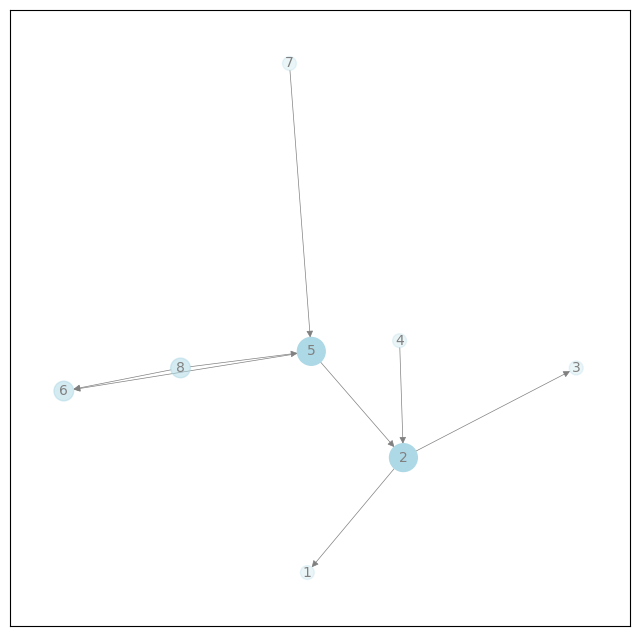

In [15]:
# plot graph -> node size and transparency: degree

plot_graph(
    graph, plot_all=True, iterations=1000, figure_size=(8, 8), node_color="lightblue"
)

The nodes in a directed cyclic graph can be defined as *ancestors* and *descendants*. The ancestor of a node *v* is another node *u* with a direct path *v* to *u*. On the other hand, the descendant node *v* has a direct path arriving from node *u*.


In [16]:
print(f"Ancestors of node 2: {nx.ancestors(graph, 2)}")
print(f"Descendants of node 2: {nx.descendants(graph, 2)}")

Ancestors of node 2: {8, 4, 5, 7}
Descendants of node 2: {1, 3}


We can also check the *topological generations*. The algorithm performs a *topological sorting* of the nodes in a way that a node in a generation is guaranted to have its ancestors in the previous generation.

In [17]:
counter = 1
for item in nx.topological_generations(graph):
    print(f"Generation {counter}: {item}")
    counter += 1

Generation 1: [4, 7, 8]
Generation 2: [5]
Generation 3: [2, 6]
Generation 4: [1, 3]


Another interesting property of a graph is the longest path between two nodes. In graphs with weighted edges, the longest path is calculated by taking the ***weighted node degree***, which is the sum of the degree of the edges connected to it, in consideration.

In [18]:
print(f"Longest path of weighted graph: {nx.dag_longest_path(graph)} (lenght={len(nx.dag_longest_path(graph)) - 1})")

Longest path of weighted graph: [4, 2, 1] (lenght=2)


Removing the weights, the longest path between two nodes is the number of edges in the path between them.

In [19]:
# removing weights to calculate the longest path of an un-weighted graph

# copy a version of the original weighted graph
graph_unweighted = graph.copy()

# print out edges' attributes
print("Weighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])

# remove weights by accessing the graph data structure
for node, edges in nx.to_dict_of_dicts(graph_unweighted).items():
    for edge, attrs, in edges.items():
        attrs.pop('weight', None)

print()

# print out edges' attributes (no weights)
print("Unweighted edges' attributes:")
for label in graph_unweighted.edges():
    print(graph_unweighted.edges()[label])


print(f"\nLongest path of unweighted graph: {nx.dag_longest_path(graph_unweighted)} (lenght={len(nx.dag_longest_path(graph_unweighted)) - 1})")

Weighted edges' attributes:
{'weight': 1, 'attribute': 'is_a'}
{'weight': 0.5, 'attribute': 'regulates'}
{'weight': 1.0, 'attribute': 'activates'}
{'weight': 0.3, 'attribute': 'a random relation'}
{'weight': 0.1, 'attribute': 'is_a'}
{'weight': 0.05, 'attribute': 'deactivates'}
{'weight': 0.7, 'attribute': 'unknown'}
{'weight': 0.7, 'attribute': 'kick'}

Unweighted edges' attributes:
{'attribute': 'is_a'}
{'attribute': 'regulates'}
{'attribute': 'activates'}
{'attribute': 'a random relation'}
{'attribute': 'is_a'}
{'attribute': 'deactivates'}
{'attribute': 'unknown'}
{'attribute': 'kick'}

Longest path of unweighted graph: [7, 5, 2, 1] (lenght=3)


The GO graph is available in the *OBO format*, a biology-oriented way to build and represent ontologies. To read and to parse the GO graph we can use the Python library *obonet* to return a NetworkX object with all the awesome functionalies to manipulate and analyze graphs. 

Below we load and parse the GO graph to print out some its basic features:

In [20]:
from obonet import read_obo

go_graph = read_obo(home_dir.joinpath("go-basic.obo"))
print(type(go_graph))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [21]:
print(f"Is Directed Acyclic Graph (DAG)?: {nx.is_directed_acyclic_graph(go_graph)}")
print(
    f"Is MultiGraph (multiple edges between two nodes)?: {go_graph.is_multigraph()}"
)
print(f"Is weighted graph: {nx.is_weighted(go_graph)}")
print(f"Number of Nodes: {go_graph.order()}")
print(f"Number of Edges: {go_graph.size()}")

Is Directed Acyclic Graph (DAG)?: True
Is MultiGraph (multiple edges between two nodes)?: True
Is weighted graph: False
Number of Nodes: 43248
Number of Edges: 84805


## **Node Degree**

The degree of each node is stored in a dictionary-like structure that can be retrieved as a list of tuples (GO term, degree) using the handy Python's list comprehension. Let's sort the nodes by descending order of degree. We use a lambda function to pass the node's degree as key for sorting and return an ordered list of tuples *(GO term, degree)*. 
Bellow we sort *in* and *out* degrees of the GO graph:

In [22]:
# print out degrees of top in-degree nodes
go_term_in_desc = sorted(go_graph.in_degree(), key=lambda x: x[1], reverse=True)

print("Degrees:\n")
for term in go_term_in_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )

Degrees:

Node: GO:0110165, in-degree: 424, out-degree: 1, degree: 425
Node: GO:0016616, in-degree: 348, out-degree: 1, degree: 349
Node: GO:0016709, in-degree: 291, out-degree: 2, degree: 293
Node: GO:0032991, in-degree: 274, out-degree: 1, degree: 275
Node: GO:0016758, in-degree: 208, out-degree: 1, degree: 209
Node: GO:0048856, in-degree: 202, out-degree: 1, degree: 203
Node: GO:0098797, in-degree: 181, out-degree: 2, degree: 183
Node: GO:0140513, in-degree: 173, out-degree: 2, degree: 175
Node: GO:0003006, in-degree: 172, out-degree: 2, degree: 174
Node: GO:0016747, in-degree: 163, out-degree: 1, degree: 164
Node: GO:0016836, in-degree: 158, out-degree: 1, degree: 159


In [23]:
# print out degrees of top in-degree nodes
go_term_out_desc = sorted(go_graph.out_degree(), key=lambda x: x[1], reverse=True)
for term in go_term_out_desc[:11]:  # print top10
    print(
        f"Node: {term[0]}, in-degree: {go_graph.in_degree(term[0])}, out-degree: {go_graph.out_degree(term[0])}, degree: {go_graph.degree(term[0])}"
    )

Node: GO:0106110, in-degree: 0, out-degree: 11, degree: 11
Node: GO:0140872, in-degree: 0, out-degree: 10, degree: 10
Node: GO:0060520, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900498, in-degree: 0, out-degree: 9, degree: 9
Node: GO:1900499, in-degree: 0, out-degree: 9, degree: 9
Node: GO:0000514, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0009102, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0010439, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0034223, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0042367, in-degree: 0, out-degree: 8, degree: 8
Node: GO:0043642, in-degree: 0, out-degree: 8, degree: 8


Analyzing the degree distribution of the network is a good start to get insight on how to use the network for useful applications.

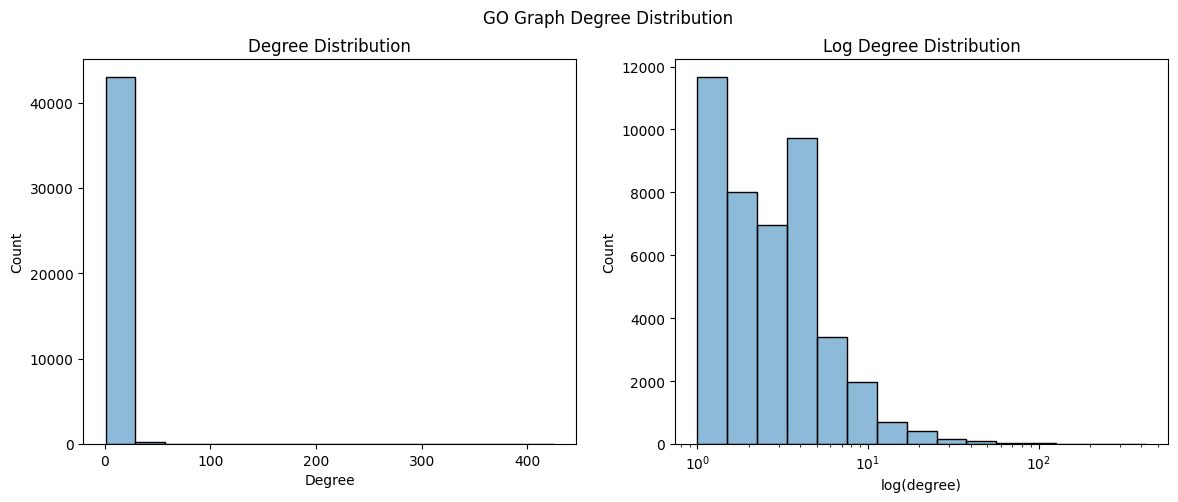

In [24]:
plot_hist_degree(go_graph, bins=15)

The degree's distribution is skewed to the left, indicating that most of the nodes have a relatively small degree. This is expected in the case of the GO graph because the GO graph is a tree.

In real-world networks, the majority of the nodes have just a few neighbors, while there is a small number of high-degree nodes referred as ***hubs***. Hubs are highly connected nodes and can be seen as the most accessed sites on the internet, or celebrities in social networks.

We also define the *average degree* of the network, a general property of graphs that indicates how connected their nodes are. For example, in two social networks with the same number of nodes, the one with higher average degree indicates that people in the network have more friends on average.

We can use `G.size()` and `G.order()` to obtain the number of edges and nodes, respectively. 

In [25]:
print(f"GO graph average degree: {(go_graph.size() / go_graph.order()):.2f}")

GO graph average degree: 1.96


The average degree of the GO graph is ~2, indicating that the average number of edges per node is small. However, we see above that there are some large hubs while more than 50% of the nodes have degree 3 or less. Inspecting such nodes can be informative for machine learning tasks because they tend to influence more the prediction of new nodes or edges.

In [26]:
from itertools import islice

# get GO degrees into a dict
go_degree_desc_dict = {}
go_degree_desc_dict = tuple_to_dict(
    sorted(go_graph.degree, key=lambda x: x[1], reverse=True), go_degree_desc_dict
)

# getting only top nodes
top_nodes_dict = dict(islice(go_degree_desc_dict.items(), 6))

# and print the GO term names

term_list = []  # keeping the terms to get their neighborhood later

for key, value in top_nodes_dict.items():
    term_list.append(key)
    print(
        f"{key} ({go_graph.nodes()[key]['namespace']}) --> {go_graph.nodes()[key]['name']}"
    )

print(f"\nTop degree list: {term_list}")

GO:0110165 (cellular_component) --> cellular anatomical entity
GO:0016616 (molecular_function) --> oxidoreductase activity, acting on the CH-OH group of donors, NAD or NADP as acceptor
GO:0016709 (molecular_function) --> oxidoreductase activity, acting on paired donors, with incorporation or reduction of molecular oxygen, NAD(P)H as one donor, and incorporation of one atom of oxygen
GO:0032991 (cellular_component) --> protein-containing complex
GO:0016758 (molecular_function) --> hexosyltransferase activity
GO:0048856 (biological_process) --> anatomical structure development

Top degree list: ['GO:0110165', 'GO:0016616', 'GO:0016709', 'GO:0032991', 'GO:0016758', 'GO:0048856']


These parent terms have broad definitions about the type of cellular compartments, biological processes and molecular functions they describe. As we move from parents to children terms we also narrow down more specific definitions. 

We can list all neighbors of a specific node. For directed graphs, the neighbors of a node are all of tis incoming and outcoming edges. Lets see the neighborhood of these terms that can be found at ***one-hop*** distance (i.e. the immediate neighboring nodes).

In [27]:
hub = term_list[0]
hub_neighbors = [n for n in nx.all_neighbors(go_graph, term_list[0])]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc[:25]:  # top 25
    print(f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]['name']}")

Neighbors of GO:0110165 (cellular anatomical entity) in descending order of degree:

GO:0005737 (degree: 21) --> cytoplasm
GO:0042995 (degree: 9) --> cell projection
GO:0005576 (degree: 7) --> extracellular region
GO:0005930 (degree: 6) --> axoneme
GO:0044304 (degree: 6) --> main axon
GO:0009425 (degree: 5) --> bacterial-type flagellum basal body
GO:0020007 (degree: 5) --> apical complex
GO:0043209 (degree: 4) --> myelin sheath
GO:0009986 (degree: 4) --> cell surface
GO:0016020 (degree: 4) --> membrane
GO:0031672 (degree: 4) --> A band
GO:0043673 (degree: 4) --> sexine
GO:1990716 (degree: 4) --> axonemal central apparatus
GO:0043668 (degree: 4) --> exine
GO:0045177 (degree: 3) --> apical part of cell
GO:0009426 (degree: 3) --> bacterial-type flagellum basal body, distal rod
GO:0060417 (degree: 3) --> yolk
GO:0032153 (degree: 3) --> cell division site
GO:0048786 (degree: 3) --> presynaptic active zone
GO:0030694 (degree: 3) --> bacterial-type flagellum basal body, rod
GO:0043218 (degree

Note that high-degree child nodes (*cytoplasm*, *cell projection*, *extracelullar region*, etc) are still broad biological definitions. For example, in the *extracelullar region* we have parent neighbors (*celullar anatomical entity*) and child terms that narrow the definitions of the extracellular region:

In [28]:
hub = "GO:0005576"
hub_neighbors = [n for n in nx.all_neighbors(go_graph, hub)]

# extract sub-graph with the neighboring nodes and get degrees in descending order
neighbors_desc = sorted(
    nx.subgraph(go_graph, set(hub_neighbors)).degree, key=lambda x: x[1], reverse=True
)

# print parent and child terms in descending order of degree
print(
    f"Neighbors of {hub} ({go_graph.nodes()[hub]['name']}) in descending order of degree:\n"
)

for term in neighbors_desc:
    print(f"{term[0]} (degree: {term[1]}) --> {go_graph.nodes()[term[0]]}")

Neighbors of GO:0005576 (extracellular region) in descending order of degree:

GO:0110165 (degree: 7) --> {'name': 'cellular anatomical entity', 'namespace': 'cellular_component', 'def': '"A part of a cellular organism that is either an immaterial entity or a material entity with granularity above the level of a protein complex but below that of an anatomical system. Or, a substance produced by a cellular organism with granularity above the level of a protein complex." [GOC:kmv]', 'is_a': ['GO:0005575']}
GO:0070701 (degree: 1) --> {'name': 'mucus layer', 'namespace': 'cellular_component', 'def': '"An extracellular region part that consists of a protective layer of mucus secreted by epithelial cells lining tubular organs of the body such as the colon or secreted into fluids such as saliva. Mucus is a viscous slimy secretion consisting of mucins (i.e. highly glycosylated mucin proteins) and various inorganic salts dissolved in water, with suspended epithelial cells and leukocytes." [GOC:

That's very cool. These graph features are easily available, and the navigation throughout the network is quite straightforward because of the concise and clear data structures. Additionally, the data structures use standard python libraries with little modifications and easy conversion between types with just a few lines of code.

In the next tutorial, we will extract the definition (*'def'*) of each GO term to use as input into a pre-trained Large Language Model (LLM) to enrich nodes' features with a vector containing the embedding of its definition. The motivation is that the approach could capture key information to better define each GO term in classification tasks.

As a bonus, we will also use the <font color="blue">GO term definition's embedding</font> to map the extracted features into a manifold using T-SNE () to verify if the the embeddings could be sufficient to define as part of the major sub-ontologies <font color="blue">(Cellular Compartiment - CC, Biological Process (BP) and Molecular Function (MF))</font>.

## **Node's attributes**

The nodes' attributes of the GO graph store information about the term. Let's print out the attributes of a random node (seriously...). Keep running the cell to explore the GO graph node-per-node :-)

In [29]:
import random

go_graph.nodes()[random.choice([x for x in go_graph.nodes()])]

{'name': 'proline catabolic process to glutamate',
 'namespace': 'biological_process',
 'alt_id': ['GO:0019494'],
 'def': '"The chemical reactions and pathways resulting in the breakdown of proline into other compounds, including glutamate." [GOC:pz]',
 'synonym': ['"proline breakdown to glutamate" EXACT []',
  '"proline degradation to glutamate" EXACT []',
  '"proline oxidation" RELATED []'],
 'xref': ['MetaCyc:PROUT-PWY', 'MetaCyc:PWY-4561'],
 'is_a': ['GO:0006536', 'GO:0006562', 'GO:0043605']}

In the node's attributes we can see some interesting features underlying each GO term. Here is a brief explanation about the essential GO term elements to describe and identify each GO term.

The *name* is a unique identifier of the term in a human-readable format.

The *namespace* is one of the three sub-ontologies aspects to which the term belongs:

- <font color="grey">***Molecular Function (MF)***</font>: specify the activities performed by the gene product, which can be "catalysis", "transport". These functions can be narrowed in more specific GO terms. "protein kinase activity" is more specific than just "catalysis"


- <font color="grey">***Cellular Component (CC)***</font>: locate the subcellular location of the gene product, which encompass compartments (e.g. 'chloroplast', 'nucleus') or macromolecular complexes such as the 'proteasome' or 'ribosome'.


- <font color="grey">***Biological Process (BP)***</font>: establish the pathway, or the molecular program, in which the gene product is involved to sustain organism's activities. Examples are 'DNA repair', 'carbohydrate metabolic process', or more general processes such as 'byosynthetic process'.

The *definition* ('def') is a concise short description of  what the GO term means for humans. It can also contains references to publications defining the term (e.g. PMID:10873824).

Finally, the *relations* between GO terms is given by keys such as *'is_a'*, or *'regulates'*. It is a GO representation of how two entities (remember, nodes are entities ) interact. There are other types of relations and we can bear in mind that the list of GO terms and the types of relations can grow overtime to accomodate precise definitions of new processes or new nuances regarding gene product's activities.

There are many additional attributes determined by the Gene Ontology Consortium, but the above ones are required to properly identify the GO term. By running the cell a couple of times you will see that the number of attributes vary but the four explained above are always there.


### **Spliting the GO Graph into Major Sub-Ontologies (CC, BP, MF)**

We can split the GO graph into three sub-graphs corresponding to the major sub-ontologies. I did it by iterating over two 'carbon-copies' of the entire GO graph and removing nodes from the copy using a conditional statement. Maybe there is an way easier way but I couldn't find it.

In [30]:
# initialize sub-ontologies graphs by copying the entire GO graph
go_graph_cc = go_graph.copy()
go_graph_bp = go_graph.copy()
go_graph_mf = go_graph.copy()

# CC
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "cellular_component":
        go_graph_cc.remove_node(term)

# BP
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "biological_process":
        go_graph_bp.remove_node(term)

# MF
for term in go_graph.nodes():
    if go_graph.nodes()[term]["namespace"] != "molecular_function":
        go_graph_mf.remove_node(term)


print(
    f"CC sub-graph --> nodes: {go_graph_cc.order()}, edges: {go_graph_cc.size()}")
print(
    f"BP sub-graph --> nodes: {go_graph_bp.order()}, edges: {go_graph_bp.size()}")
print(
    f"MF sub-graph --> nodes: {go_graph_mf.order()}, edges: {go_graph_mf.size()}")


CC sub-graph --> nodes: 4043, edges: 6498
BP sub-graph --> nodes: 27942, edges: 64560
MF sub-graph --> nodes: 11263, edges: 13747


With these counts of nodes and edges we can infer some interesting insights. We can check the average degrees and rank nodes' degrees in each graph. This will allow us to determine their hubs considering only one sub-ontolgy at a time.

CC sub-graph average degree: 1.61


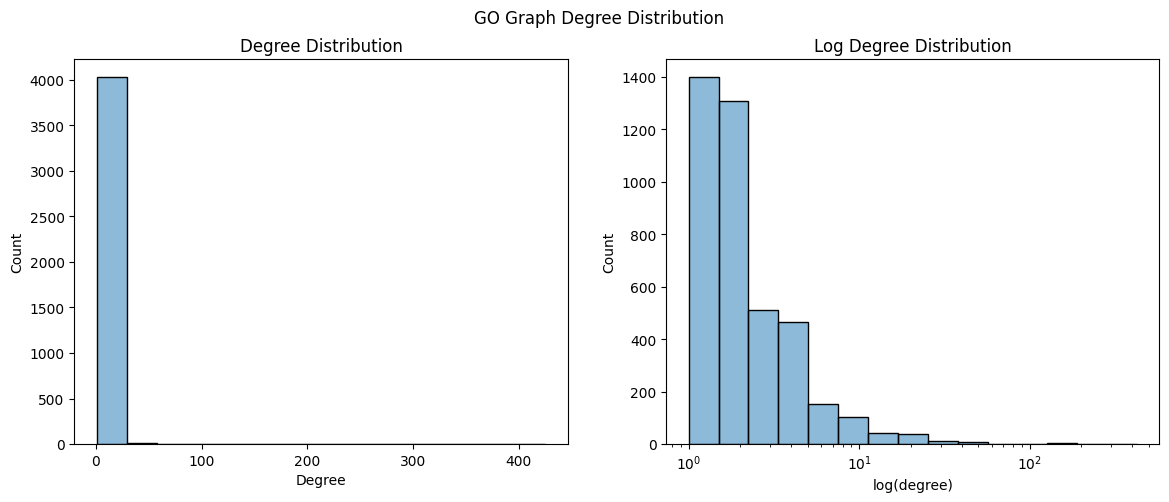

In [31]:
# Cellular Component

print(f"CC sub-graph average degree: {(go_graph_cc.size() / go_graph_cc.order()):.2f}")

plot_hist_degree(go_graph_cc)

MF sub-graph average degree: 1.22


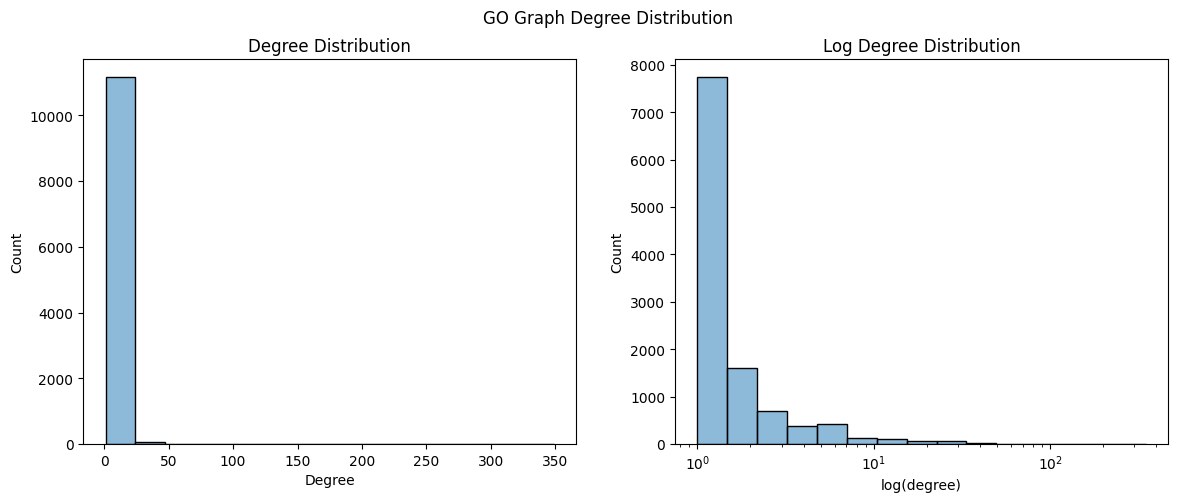

In [32]:
# Molecular Function

print(f"MF sub-graph average degree: {(go_graph_mf.size() / go_graph_mf.order()):.2f}")

plot_hist_degree(go_graph_mf)

BP sub-graph average degree: 2.31


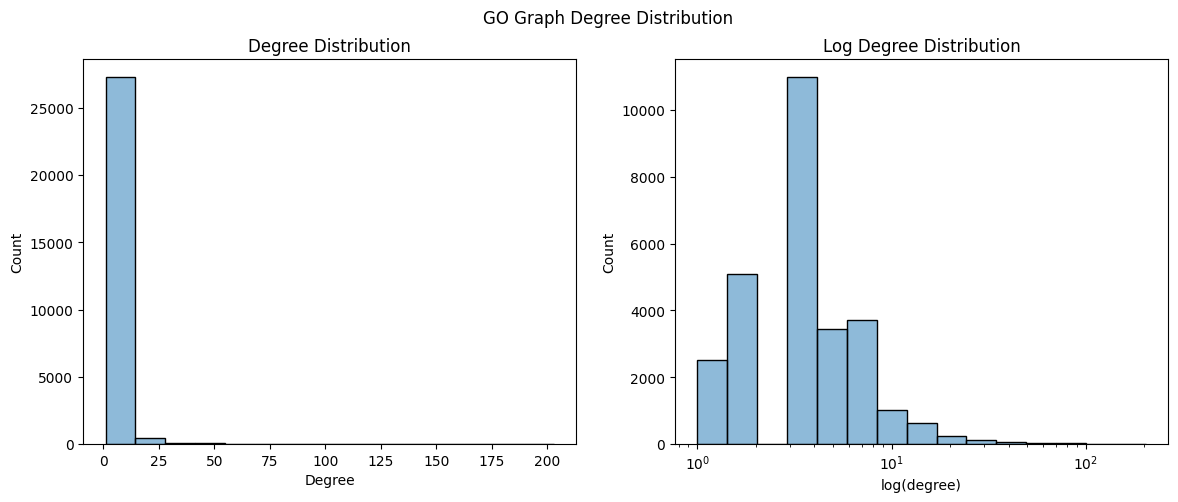

In [33]:
# Biological Process

print(f"BP sub-graph average degree: {(go_graph_bp.size() / go_graph_bp.order()):.2f}")

plot_hist_degree(go_graph_bp)

The degree distribution of the sub-ontologies Celullar Component and Molecular Function have fairly similar distributions. However, the nodes corresponding to Biological Process sub-ontology have predominance of degrees with higher degrees when compared to the CC and MF. The higher connectivity of BP's nodes could be due to the 'fuzziness' (I couldn't think of a word better than this) of this sub-ontology, where biological processes can be seen as pathways that are involved in cross-talk of enzimatic steps, or be associated to overlaping components of different pathways. For example, glucose metabolism is the entry-point for energy metabolism and the metabolites in the pathway are substrates for many biosynthetic reactions.

### **Graph Visualization**

We can plot the graph to grasp its general aspects. However, graphs for machine learning applications are usually large and plotting all nodes and edges can be computionally expensive and somewhat useless. The custom function `plot_graph` can be used with a list of nodes, and we will be plotting the nodes with the highest degree. The function plots nodes' sizes and transparencies (*alpha*) according to its relative degree. We need to select a subset of the nodes because the GO graph is huge and would take a lot of time to plot and vizualization can be dificult. Another parameter is to set the number of iterations to determine the best distance between nodes. The [spring_layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html) algorithm of NetworkX treats edges as springs bringing nodes together, and nodes has repelling objects. The simulation usually stops when these forces (and positions) are close to the equilibrium or until reach the number of iterations we define.

Let's plot the sub-ontologies graphs:

Plotting subgraph with 200 nodes and 272 edges...


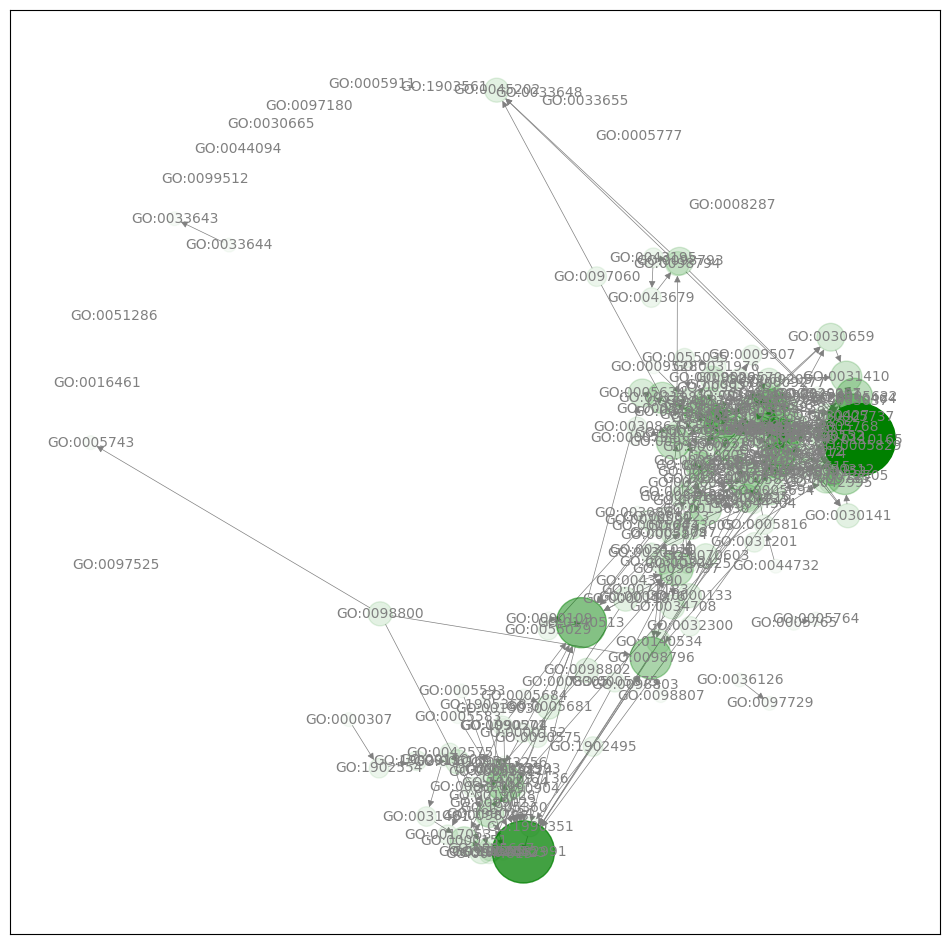

In [34]:
# Cellular Component network plot (highest degrees)

plot_graph(
    go_graph_cc,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_cc.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)

Plotting subgraph with 200 nodes and 145 edges...


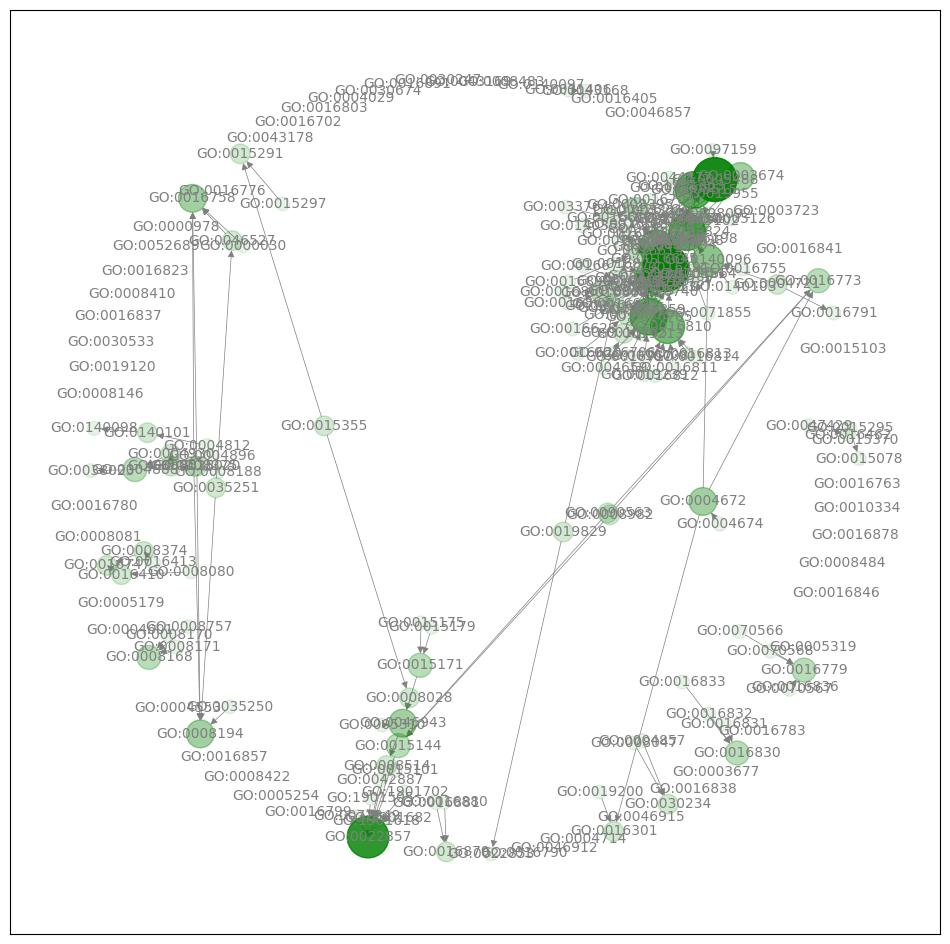

In [35]:
# Molecular Function network plot (highest degrees)

plot_graph(
    go_graph_mf,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_mf.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)

Plotting subgraph with 200 nodes and 292 edges...


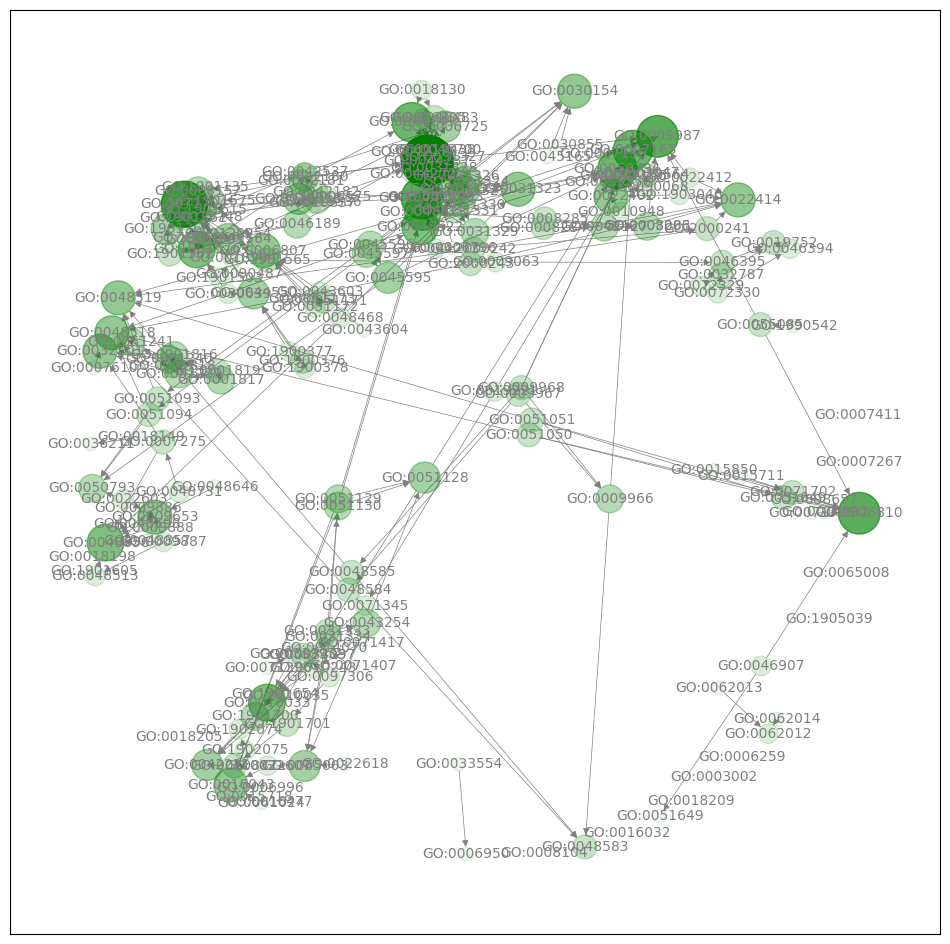

In [36]:
# Biological Process network plot (highest degrees)

plot_graph(
    go_graph_bp,
    plot_all=False,
    plot_nodes=[
        x[0] for x in sorted(go_graph_bp.degree, key=lambda x: x[1], reverse=True)
    ],
    num_nodes=200,
    iterations=1000,  # increase iterations to optimize nodes' distances
)

The GO graph has information about the GO terms stored in the nodes as attributes, as well as the type of relations between the nodes. We can access these attributes by specifying the GO term as key in the graph.nodes() object.

## **Appendix: Converting the GO terms attributes into a Pandas Dataframe**

You might want to extract GO graph attributes into a dataframe. Dataframes are commom data structures in machine learning and are easier to manipulate and analyze because there are plenty of libraries and snipets to help in this task. We lose the topological information about the data but manipulating the dataset with Pandas can be useful (and easier) sometimes. Just a few lines of code do the job:

In [37]:
import pandas as pd

# creating a list with GO term definitions (the magic of list comprehension)
go_def_list = [go_graph.nodes()[term] for term in go_graph.nodes()]

# add features
go_df = pd.DataFrame.from_dict(go_def_list, orient="columns")

# insert column with GO term IDs (ordered)
go_df.insert(0, "go_term", list(go_graph.nodes()))

print(f"GO dataframe shape: {go_df.shape}")
go_df.head()


GO dataframe shape: (43248, 11)


,go_term,name,namespace,def,synonym,is_a,alt_id,subset,xref,relationship,comment
0,GO:0000001,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]","[GO:0048308, GO:0048311]",NaN,NaN,NaN,NaN,NaN
1,GO:0000002,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",NaN,[GO:0007005],NaN,NaN,NaN,NaN,NaN
2,GO:0000003,reproduction,biological_process,"""The production of new individuals that contai...","[""reproductive physiological process"" EXACT []]",[GO:0008150],"[GO:0019952, GO:0050876]","[goslim_agr, goslim_chembl, goslim_flybase_rib...",[Wikipedia:Reproduction],NaN,NaN
3,GO:0000006,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran...",[GO:0005385],NaN,NaN,NaN,NaN,NaN
4,GO:0000007,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",NaN,[GO:0005385],NaN,NaN,NaN,NaN,NaN


Looking at the definition of GO terms, we see that 'name', 'namespace' and 'def' are commont to all GO term nodes, but there are more items in the GO terms nodes that are not. These will result in NaN (Not a Number) in the dataframe. We can get rid of it or replace by a more useful value. We can also add other informations to the dataframe such as degrees of nodes, embeddings of the text information (the term definitions, for example), or we can also merge other gene or protein-related datasets such as from BioGRID (protein-protein interactions) or UniProt (functional annotation of proteins)...

## **Conclusion**

Good data visualization techniques can be unusual sometimes, but these can also provide interesting insights on the data. There are many tools that can be match and mixed together to derive useful techniques to obtain key insights and features hidden amongst samples and variables.